# 

In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as ud
from torchvision import transforms
from torchvision import datasets
from PIL import Image
import cv2
import glob
import json

## 模型数据准备，数据扩增

In [91]:
# 进行数据扩展

class SVHDataset(ud.Dataset):
    def __init__(self, img_pattern, label_folder, transform=None):
        self.img_path = glob.glob(img_pattern)
        self.img_label = [v['label'] for k,v in json.load(open(label_folder)).items()]
        self.img_path.sort()
        self.transform = transform
    def __getitem__(self, index):
        """
        实现了切片方法的获取
        """
        # 批量读取数据
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        # 将原始数据分类10为0, 保证有五位数字
        # example: [10]*2 = [10, 10], [2, 3] + [10] = [2, 3, 10]
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl) + (5 - len(lbl))*[10]
        return img, torch.Tensor(lbl[:5])
    def __len__(self):
        return len(self.img_path)

In [98]:
# 数据扩充和训练规范化
data_transforms = {
    'train': transforms.Compose([
                # 缩放到固定尺⼨
                transforms.Resize((64, 128)),
                transforms.RandomCrop((60, 120)),
                transforms.ColorJitter(0.3, 0.3, 0.2),
                # 加⼊随机旋转
                transforms.RandomRotation(10),
                # 将图⽚转换为pytorch 的tesntor
                transforms.ToTensor(),
                # 对图像像素进⾏归⼀化
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
    'val': transforms.Compose([
                # 缩放到固定尺⼨
                transforms.Resize((60, 128)),
                # 将图⽚转换为pytorch 的tesntor
                transforms.ToTensor(),
                # 对图像像素进⾏归⼀化
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
}

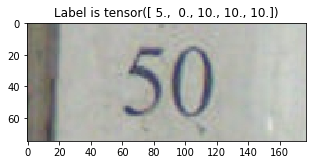

In [99]:
# 测试切片的方法
img_01, label_01 = SVHDataset('Datasets/mchar_train/*.png', 'Datasets/mchar_train.json')[np.random.choice(range(30000))]
plt.figure(figsize=(5, 5))
plt.title('Label is %s' % label_01)
plt.imshow(img_01)

In [100]:
import sys

EPOCH = 2000
BATCH_SIZE = 25
USE_CUDA = True

train_loader = ud.DataLoader(
    dataset=SVHDataset('Datasets/mchar_train/*.png', 'Datasets/mchar_train.json', data_transforms['train']),
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers 在windows上报错 设置改为 0
    num_workers= (0 if sys.platform.startswith('win') else 10)
)
val_loader = ud.DataLoader(
    dataset=SVHDataset('Datasets/mchar_val/*.png', 'Datasets/mchar_val.json', data_transforms['val']),
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers 在windows上报错 设置改为 0
    num_workers= (0 if sys.platform.startswith('win') else 10)
)

## 模型结构定义

In [101]:
from torchvision import models

# 初始化构建线性网络
class SVHN_Model(torch.nn.Module):
    def __init__(self, path=None):
        super(SVHN_Model, self).__init__()
        if path is None:
            model_conv = models.resnet18(pretrained=True)
        else:
            model_conv = models.resnet18(pretrained=False)
            model_conv.load_state_dict(torch.load(path))
        model_conv.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        model_conv = torch.nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        # 每个字符有11中情况
        self.fc1 = torch.nn.Linear(512, 11)
        self.fc2 = torch.nn.Linear(512, 11)
        self.fc3 = torch.nn.Linear(512, 11)
        self.fc4 = torch.nn.Linear(512, 11)
        self.fc5 = torch.nn.Linear(512, 11)
    def forward(self, img):
        # activation function for
        feat = F.dropout2d(self.cnn(img), p=0.3)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

## 验证、训练、预测方法定义

In [102]:
from functools import reduce

def train_def(train_loader, model, loss_func, optimizer):
    
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for step, (batch_x, batch_y) in enumerate(train_loader):
        # train your data...
        if USE_CUDA:
            batch_x = batch_x.cuda()
            # 将 float32 强制转换为 long
            batch_y = batch_y.long().cuda()
        predicate = model(batch_x)
        loss = reduce(lambda x, y: x + y, [loss_func(predicate[m], batch_y[:, m]) for m in range(batch_y.shape[1])])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    return np.mean(train_loss)
        
def validate_def(val_loader, model, loss_func):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    # 不记录模型梯度信息
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(val_loader):
            if USE_CUDA:
                batch_x = batch_x.cuda()
                # 将 float32 强制转换为 long
                batch_y = batch_y.long().cuda()
            predicate = model(batch_x)
            loss = reduce(lambda x, y: x + y, [loss_func(predicate[m], batch_y[:, m]) for m in range(batch_y.shape[1])])
            val_loss.append(loss.item())
    return np.mean(val_loss)

def predict_def(test_loader, model, tta=10):
    
    model.eval()
    test_pred_tta = None

    # TTA 次数
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            for step, (batch_x, batch_y) in enumerate(test_loader):
                if USE_CUDA:
                    batch_x = batch_x.cuda()
                predicate_y = model(batch_x)
                output = torch.stack(predicate_y, dim=1)
                # 最大概率的索引值
                output = torch.argmax(output, dim=2)
                test_pred.append(output)
        
        test_pred = torch.cat(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    return test_pred_tta

## 模型执行

In [ ]:
model = SVHN_Model(path='resnet18-5c106cde.pth')  # define the network
if USE_CUDA:
    model = model.cuda()

# 开启训练模式

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
# the target label is NOT an one-hotted
loss_func = torch.nn.CrossEntropyLoss()

best_loss = 10

train_loss_list = []
val_loss_list = []
val_char_acc_list = []

for epoch in range(EPOCH):
    
    train_loss = train_def(train_loader, model, loss_func, optimizer)
    val_loss = validate_def(val_loader, model, loss_func)

    val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
    val_predict_label = predict_def(val_loader, model, 1)
    val_label_pred = [''.join(map(lambda x: str(x.item()), labels[labels!=10])) for labels in val_predict_label]
    
    # score 评价得分
    val_char_acc = np.sum(np.array(val_label_pred) == np.array(val_label)) / len(val_label)
    
    #将值添加到list
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_char_acc_list.append(val_char_acc)
    
    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}'.format(epoch, train_loss, val_loss))
    print('Val Acc', val_char_acc)
    
    # 记录下验证集最佳精度
    if val_loss < best_loss:
        best_loss = val_loss
        print('Find better model in Epoch {0}, saving model.'.format(epoch))
        # 保存模型参数
        torch.save(model.state_dict(), './model.pt')

Epoch: 0, Train loss: 3.881897701819738 	 Val loss: 4.704136683344841
Val Acc 0.0093
Find better model in Epoch 0, saving model.
Epoch: 1, Train loss: 2.4829599538445475 	 Val loss: 3.207984266281128
Val Acc 0.0122
Find better model in Epoch 1, saving model.
Epoch: 2, Train loss: 2.0746330789228282 	 Val loss: 3.1508462110161783
Val Acc 0.0103
Find better model in Epoch 2, saving model.
Epoch: 3, Train loss: 1.8537898908555508 	 Val loss: 2.8045072400569917
Val Acc 0.0107
Find better model in Epoch 3, saving model.
